# Diabetes Dataset Process and Results
Nathaniel Richards - 10/23/18

From UCI ML Repository    
["Diabetes 130-US hospitals for years 1999-2008 Data Set"](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008#)

**Goal**: build model(s) to predict which patients will be re-hospitalized within 30 days

**Evaluate**: using AUROC

Notes:
- 'encounter_id' - unique admissions
- ignore 'patient_nbr' - treat all encounters independent
- 'readmitted' - treat 'NO' as '>30'
- Attributes: 55
- Samples: >100k
- Features: numerical, categorical

## Basic Approach

1. Exploration
    1. feature names
    1. feature types
    1. missing values
    1. numerical histograms
    1. categorical value counts
1. Preprocessing
    1. drop rows
        - missing data
        - other insights from exploration
    1. recode categorical features
        - reduce dimensionality
    1. convert types
        - numerical to categorical
        - categorical to numerical
    1. determine feature subset
    1. upsampling / downsampling
    1. train / validation / test split
1. Modeling
    1. Baseline models
        - logistic regression
        - SVC
    1. Advanced models
        - DNN w/ categorical embedding

## Considerations

1. Imbalanced classes
    - <30 only accounts for 11% of data
1. Upsampling / downsampling
    - Must be careful if upsampling, risk of information leakage between train/test
1. Train / val / test split
    - Ensure no information leakage, otherwise overly optimistic results

## Literature Survey

After planning out how I would approach this problem, I did some research on how others    
have performed on this open-source dataset.  Listed below are some articles that I found,   
including my inspiration and comments.

### [How to use machine learning to predict hospital readmissions?](https://medium.com/@uraza/how-to-use-machine-learning-to-predict-hospital-readmissions-part-1-bd137cbdba07)   
by Usman Raza

Reported test accuracy: 94%

Notes
- remove weight, payer_code, medical_specialty
- recode diagnoses {1,2,3}
- group similar admission/discharge categories
- convert age ranges to numerical mean
- drop subjects' second, third, etc visits

Pros
- extremely thorough set of blog posts
- insightful feature engineering/reduction
- references the paper associated with dataset
- uses pandas
- strong statistical background

Cons
- **overinflated train/test performance**

Why? Because of the way he performed upsampling.  He performed SMOTE upsampling   
*before* the train/test split, causing much of the training data information to end up    
in the test set.  This is how he was able to achieve such a high accuracy/AUROC    
compared to other literature.


### [STATS701 Project](https://jrfarrer.github.io/stat701_miniproject/)
by Jordan Farrer

Reported AUROC: <0.64

Notes
- confirms that modeling is difficult/impossible with such unbalanced classes

Pros
- great visualization, exploration

Cons
- did not perform upsampling/downsampling, left classes unbalanced
- poor model performance as a result
- similar performance to naive model (only predicting one class)
- unbalanced confusion matrix


### [Predicting Hospital Readmission for Patients with Diabetes Using Scikit-Learn](https://towardsdatascience.com/predicting-hospital-readmission-for-patients-with-diabetes-using-scikit-learn-a2e359b15f0)
by Andrew Long

Reported AUROC: ~0.65

Notes
- recode medical_specialty categories
- most weight values missing, but adds feature 'has_weight' as presence of weight record
- many models evaluated
- reports AUC
- performs hyperparameter optimization

Pros
- follows clear data science process
- train / val / test split
- properly performs subsampling after train/val split
- performs continuous feature scaling

Cons
- one-hot encoding? - may not be negative


## Other Resources

### [The Right Way to Oversample in Predictive Modeling](https://beckernick.github.io/oversampling-modeling/)
by Nick Becker

This article details the subtle-yet-dangerous pitfall of performing upsampling incorrectly.     
One should apply SMOTE upsampling *after* the train/test split, otherwise information will leak    
between the train/test sets, resulting in inflated performance - the model has already trained    
on the data in the test set.

### [Building A Logistic Regression in Python, Step by Step](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8)
by Susan Li

- Converts categorical features to one-hot
- Performs SMOTE on one-hot
- Properly performs SMOTE on train set after train/test split
- Recursive feature elimination (RFE)

## Expectations

I first came upon the results from [Usman Raza](https://medium.com/@uraza/how-to-use-machine-learning-to-predict-hospital-readmissions-part-1-bd137cbdba07) that reported 94% test accuracy on the Diabetes dataset.

However, these results were inflated (see above), and other results show an average test    
performance around AUC=0.65 .  In my model evaluation, this is my target to meet or exceed.

In [38]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import numpy as np
import pandas as pd
import os
import sys
import pprint

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
plt.style.use('ggplot')
sns.set()
# plt.style.use('seaborn')
mpl.style.use('seaborn')

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 999
pd.options.display.max_rows = 500
np.set_printoptions(precision=6)

DATA_PATH = '../data'
RESULTS_PATH = '../results/00_baseline/'
pp = pprint.PrettyPrinter(indent=4)

print(pd.__version__)

# UGLY HACK - not for production
sys.path.append('..')

0.23.4


# Preprocessing

1. Recast output
    - 'NO' as '>30'
1. Cast age as numerical value
    - mean of given range
1. Drop values
    - patients' second, third, etc. encounters
    - missing gender
    - missing diag_1
    - encounters related to death/expiration
1. Log transform numerical features
    - 'number_emergency', 'number_inpatient', 'number_outpatient'
1. Remove outliers from continuous features
1. Recode diagnoses to 8 sub-categories
1. Recode admission and discharge IDs
1. Identify and remove imbalanced categorical features
    - based on specified threshold
1. Label encode categories

### Splitting and Sampling
1. Train/Validation/Test split: 80/10/10
1. Upsample train set
    - upsample <30 with replacement
1. Downsample validation and test sets
    - downsample >30 without replacement

Upsampling and downsampling were necessary to balance the output categories,  
as <30 only accounted for ~11% of samples.  Upsampling of the train set allowed   
for maximum use of all unique >30 samples.  Upsampling was performed on the train   
set and not the whole dataset to prevent information leakage between train/val/test.

# Model Architecture

I decided to take on the challenge of implementing a more advanced model -   
a deep neural network with categorical embeddings.  This type of model is   
able to handle both continuous (numerical) and categorical features. 

### Embeddings
There were 18 categorical variables selected as inputs, so there are 18 embedding   
matrices - the size of which are calculated by `min(50, (x + 1) // 2)`, where `x`   
is the number of unique category values for that variable.

### Inputs
The categorical features are applied through the embedding, then a `Dropout` layer   
specificially for the embeddings.  The continuous features are first passed through   
a `BatchNorm`, so no normalization is required in preprocessing.  The resulting   
categorical and continuous input vectors are concatenated and passed to the fully   
connected layers

### Hidden Layers
Each hidden layer consists of a `Linear` layer, `LeakyReLU` activation function,   
`BatchNorm`, and `Dropout`.

The resulting (seemingly large) number of hidden layers is a result of hand-tuning,   
observing that increased network depth aided significantly in reducing overfitting.

### Output
After the last hidden layer, there exists a final `Linear` layer with no `Batchnorm`   
or `Dropout`.  This vector is passed through a final `Sigmoid` function to constrain   
the output to `[0,1]`, as this is a binary classification problem.

In [40]:
import utils

model = utils.load_model(RESULTS_PATH + 'model.pt')
display(model)

Network(
  (embeddings): ModuleList(
    (0): Embedding(6, 3)
    (1): Embedding(2, 1)
    (2): Embedding(4, 2)
    (3): Embedding(22, 11)
    (4): Embedding(15, 8)
    (5): Embedding(9, 5)
    (6): Embedding(10, 5)
    (7): Embedding(10, 5)
    (8): Embedding(4, 2)
    (9): Embedding(4, 2)
    (10): Embedding(4, 2)
    (11): Embedding(4, 2)
    (12): Embedding(4, 2)
    (13): Embedding(4, 2)
    (14): Embedding(4, 2)
    (15): Embedding(4, 2)
    (16): Embedding(2, 1)
    (17): Embedding(2, 1)
  )
  (dropout_emb): Dropout(p=0.5)
  (bn_continuous): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_layers): ModuleList(
    (0): FCUnit(
      (linear): Linear(in_features=67, out_features=512, bias=True)
      (batchnorm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.65)
    )
    (1): FCUnit(
      (linear): Linear(in_features=512, out_features=256, bias=True)
      (batchnorm): BatchNorm1

# Model Training

Given the time constraints, all of the model and training hyperparameters   
were simply hand-tuned.  Parameters were tuned by observing the train   
and validation performance over the epochs, and adjusted for signs of    
overfitting or underfitting

### Experiment parameters

See model and training parameters below:

```
{
  "name": "00_baseline",
  "dataset": "baseline",
  "batch_size": 1024,

  "model": {
    "dropout_emb": 0.5,
    "dropout_fc": 0.5,
    "size_fc": [512, 256, 64, 64, 64],
    "size_final": 64
  },

  "learning_rate": 1e-3,
  "max_epochs": 50
}
```

### Saving the model
If a new best validation AUROC was achieved, the model was saved at that epoch.    
One can see in the figures below that the model starts to overfit around halfway   
to the end of the epochs - as the training and validation curves cross and start    
to diverge.

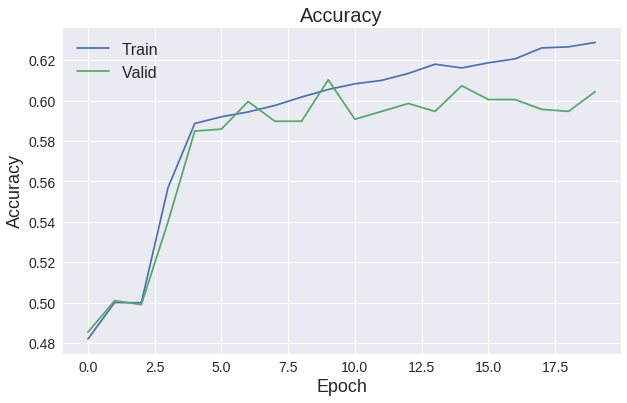

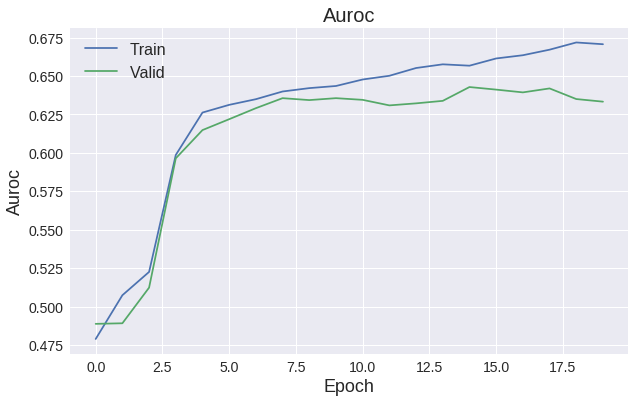

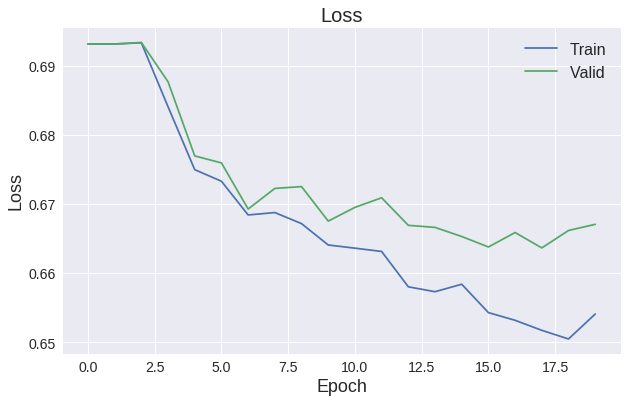

In [41]:
import evaluate

metrics = evaluate.metrics

train_metrics = pd.read_csv(RESULTS_PATH + 'train_hist.csv')
valid_metrics = pd.read_csv(RESULTS_PATH + 'valid_hist.csv')

for metric in list(metrics.keys()) + ['loss']:
    f, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(train_metrics.index, train_metrics[metric], 'C0', label='Train')
    ax.plot(valid_metrics.index, valid_metrics[metric], 'C1', label='Valid')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(metric.capitalize(), fontsize=20)
    
    ax.legend()
    legend = ax.legend(
        loc='best',
#         bbox_to_anchor=(1.2, 1.0),
        frameon=False,
        fancybox=False,
        ncol=1,
        fontsize=16
    )

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(14)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    
    plt.show()


One can see (above) that the model generalizes fairly well from the train set   
to the validation set, as the metric curves follow each other closely - as the   
train performance improves, so does the validation performance.

# Model Performance Evaluation

In [45]:
import torch
import utils
import model.data_loader as data_loader

metrics = evaluate.metrics
loss_fn = torch.nn.BCELoss()

# params = {'device': torch.device('cuda')}
params_path = '../experiments/00_baseline.json'
features_path = '../data/processed/baseline/features.json'

params = utils.Params()
params.load(params_path)
features = utils.Features()
features.load(features_path)

params['device'] = torch.device('cuda')

dataloaders = data_loader.fetch_dataloaders(data_dir='../data/processed/', features=features, params=params)
for phase in ['train', 'val', 'test']:
    size = 0
    for batch, _, _ in dataloaders[phase]:
        size += len(batch)
    print(f'{phase.capitalize()} samples: {size}')

Train samples: 91392
Val samples: 1024
Test samples: 1024


In [43]:
import evaluate

performance = {}
for phase in ['train', 'val', 'test']:
    dataloader = dataloaders[phase]
    phase_metrics, phase_confusion = evaluate.evaluate(model, loss_fn, dataloader, metrics, params)
    performance[phase] = phase_metrics
    
    print(f'{phase.capitalize()}:')
    for metric in phase_metrics.keys():
        print(f'\t{metric.capitalize()}: {phase_metrics[metric]:0.4f}')
    print(f'\tConfusion Matrix:')
    print(phase_confusion)
    print()

Train:
	Accuracy: 0.6164
	Auroc: 0.6570
	Loss: 0.6584
	Confusion Matrix:
[[31360. 14326.]
 [20733. 24973.]]

Val:
	Accuracy: 0.6074
	Auroc: 0.6428
	Loss: 0.6653
	Confusion Matrix:
[[353. 158.]
 [244. 269.]]

Test:
	Accuracy: 0.6260
	Auroc: 0.6650
	Loss: 0.6579
	Confusion Matrix:
[[353. 158.]
 [225. 288.]]



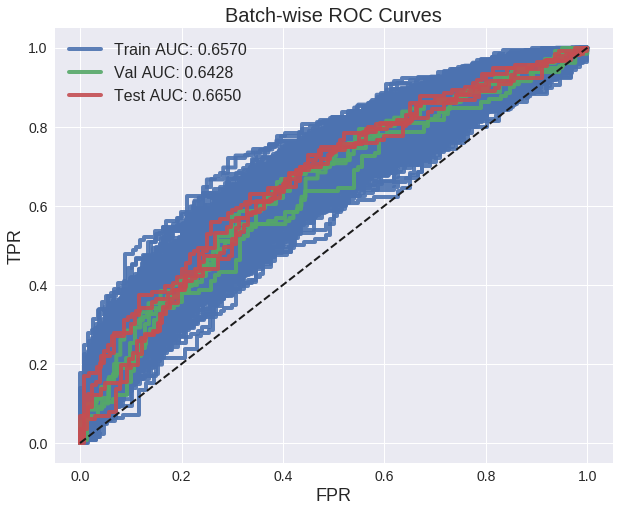

In [44]:
from sklearn.metrics import auc

f, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, phase in enumerate(['train', 'val', 'test']):
    dataloader = dataloaders[phase]
    phase_fpr, phase_tpr = evaluate.evaluate_roc(model, dataloader, params)
    
    for j, (fpr, tpr) in enumerate(zip(phase_fpr, phase_tpr)):
        if j == 0:
            label = f"{phase.capitalize()} AUC: {performance[phase]['auroc']:0.4f}"
#             label = f"{phase.capitalize()} AUC: {auc(fpr, tpr):0.4f}"
        else:
            label = None
        ax.plot(fpr, tpr, color=f'C{i}', lw=4, alpha=0.9, label=label)

ax.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('Batch-wise ROC Curves', fontsize=20)

ax.legend()
legend = ax.legend(
    loc='best',
#         bbox_to_anchor=(1.2, 1.0),
    frameon=False,
    fancybox=False,
    ncol=1,
    fontsize=16
)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)

plt.show()

# Results

| Metric   | Train  | Val    | Test   |
|----------|--------|--------|--------|
| Accuracy | 0.6164 | 0.6074 | 0.6260 |
| AUROC    | 0.6570 | 0.6428 | 0.6650 |
| Loss     | 0.6584 | 0.6653 | 0.6579 |

From the training curves, resulting metrics, and ROC curves (below), one   
can see that the model generalized quite well - as all metrics between   
train, validation, and test sets are close.

These results are comparable with that achieved by [Andrew Long](https://towardsdatascience.com/predicting-hospital-readmission-for-patients-with-diabetes-using-scikit-learn-a2e359b15f0),
who properly performed upsampling of the training set.   
As mentioned before, the results of [Uzman Raza](https://medium.com/@uraza/how-to-use-machine-learning-to-predict-hospital-readmissions-part-1-bd137cbdba07) are likely overinflated due to improper upsampling.

## Outcomes
This project confirmed the feasibility of applying a relatively new technique of   
categorical embeddings to create mixed-input deep neural network models.   
The resulting network did not catestrophically overfit to the train set, but in   
fact generalized well.

## Improvements
As this network was simply hand-tuned, there are several improvements to be made:

1. Hyperparameter optimization
    - dropout rates
    - layer depth/sizes
    - learning rate
    - optimizer and lr scheduler parameters
1. Visualize embeddings
    - see if network learned any meaningful clustering of categories
    
Thank you for reading!
